In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import the necessary packages
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten

class LeNet(Module):
    def __init__(self, numChannels, classes):
        super(LeNet, self).__init__()

        # CONV => RELU => POOL
        self.conv1 = Conv2d(in_channels=numChannels, out_channels=20, kernel_size=(5,5))
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2,2), stride=(2,2))

        # second set of CONV layers
        self.conv2 = Conv2d(in_channels=20, out_channels=50, kernel_size=(5,5))
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(2,2), stride=(2,2))

        # FC layer
        self.fc1 = Linear(in_features=800, out_features=500)
        self.relu3 = ReLU()

        # softmax
        self.fc2 = Linear(in_features=500, out_features=classes)
        self.logSoftmax = LogSoftmax(dim=1)

    def forward(self, x):
        hidden_states = []
        
        # pass the input through our first set of CONV => RELU =>
        # POOL layers
        x = self.conv1(x)
        #hidden_states.append(x.clone())
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        # pass the output from the previous layer through the second
        # set of CONV => RELU => POOL layers
        x = self.conv2(x)
        #hidden_states.append(x.clone())
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        # flatten the output from the previous layer and pass it
        # through our only set of FC => RELU layers
        x = flatten(x, 1)
        x = self.fc1(x)
        #hidden_states.append(x.clone())
        x = self.relu3(x)
        
        # pass the output to our softmax classifier to get our output
        # predictions
        x = self.fc2(x)
        output = self.logSoftmax(x)
        
        # return the output predictions
        return output, hidden_states
    

-----------------------------------

In [ ]:
pretrained_model = "kd_reg_e2.pth"
use_cuda=True
# Set random seed for reproducibility
torch.manual_seed(42)

In [ ]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='evaldata', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")

def load_model(path):
    # Initialize the network
    model = LeNet(numChannels=1, classes=10).to(device)
    
    # Load the pretrained model
    model = torch.load(path, map_location=device)
    
    # Set the model in evaluation mode. In this case this is for the Dropout layers
    model.eval()

    return model

In [ ]:
# PGD Attack
# MNIST init
def pgd_attack(model, images, labels, eps=0.3, alpha=2/255, iters=40) :
    images = images.to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()
        
    ori_images = images.data
        
    for i in range(iters) :    
        images.requires_grad = True
        outputs, hs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
            
    return images

In [ ]:
epsilons = [0, .1, .2, .3, .4, .5]
models = ['no_reg.pth', 'kd_reg_e2.pth', 'kd_reg_e3.pth']

X = []
y = []

for idx, m in enumerate(models):
    mod = load_model(m)

    push = []
    
    for e in epsilons:
        total = 0
        correct = 0
        
        for i, l in test_loader:
            images = pgd_attack(mod, i, l, e, iters=20)
            labels = l.to(device)

            outputs, hs = mod(images)
    
            _, pre = torch.max(outputs.data, 1)
        
            total += 1
            correct += (pre == labels).sum()

        push.append(correct / total)
            
        print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

    y.append(push)
    X.append(epsilons)

---------------------------------------------

In [5]:
import pickle

epsilons = [0, .1, .2, .3, .4, .5]
# Open the file in binary read mode
with open('pgd_outputs.pkl', 'rb') as file:
    # Load the data
    X, y = pickle.load(file)

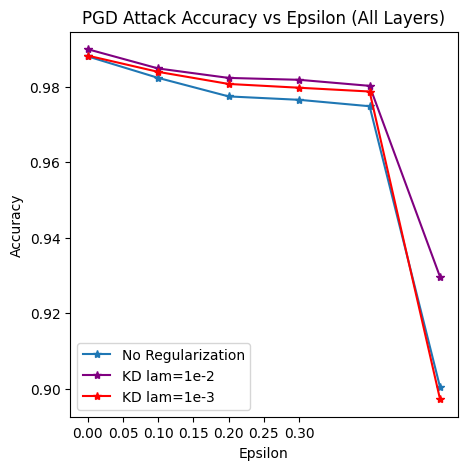

In [6]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, [x.cpu() for x in y[0]], "*-", label='No Regularization')
plt.plot(epsilons, [x.cpu() for x in y[1]], "*-", color='purple', label='KD lam=1e-2')
plt.plot(epsilons, [x.cpu() for x in y[2]], "*-", color='red', label='KD lam=1e-3')
#plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("PGD Attack Accuracy vs Epsilon (All Layers)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('pgd_all_vs_ep.pdf')
plt.show()

In [29]:
import pickle

# Specify the file path where you want to save the object
file_path = 'pgd_outputs.pkl'

# Open the file in binary write mode
with open(file_path, 'wb') as file:
    # Use pickle to serialize and save the object to the file
    pickle.dump((X, y), file)

In [11]:
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))

In [13]:
force_cudnn_initialization()

RuntimeError: cuDNN error: CUDNN_STATUS_NOT_INITIALIZED